In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from hmmlearn import hmm

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


# Now we make it a multinomial to reproduce results

In [16]:

##############################################################
# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([1, 0, 0, 0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0, 0, 0, 1],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 10.0],
                  [10.0, 10.0],
                  [10.0, 0.0]])
# The covariance of each component
# Sampling for the observing model
# covars = .1 * np.tile(np.identity(2), (4, 1, 1))

#Probability of emitting value from a given state
# n_components,n_features
r_corr = 1
emissionprob = np.array([[r_corr, 1 - r_corr, 0, 0],
                        [0, r_corr, 1 - r_corr, 0],
                        [0, 0, r_corr, 1 - r_corr],
                        [1 - r_corr, 0, 0, r_corr]])

# Build an HMM instance and set parameters
model_d = hmm.MultinomialHMM(n_components=4)

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model_d.startprob_ = startprob
model_d.transmat_ = transmat
model_d.means_ = means
model_d.emissionprob_ = emissionprob
###############################################################

# Generate samples
X, Z = model_d.sample(100000)


In [17]:
def run_trials(X,num=20,num_comp=4):
    best_mod = None
    sc = 0
    best = -np.inf
    for i in range(num):
        mod = hmm.MultinomialHMM(n_components=num_comp)
        mod.fit(X)
        sc = mod.score(X)
        print('Score of {}:'.format(i),sc)
        if sc > best:
            best = sc
            best_model = mod
            print('New best', best)
        
    return best_model, best
    
    
best_mod,best_sc = run_trials(X,3)


Score of 0: 0.0
New best 0.0
Score of 1: 0.0
Score of 2: 0.0


# We need to take the environment samples and use them to get the next agent state
The agent was trained with the goal of maximizing log likelihood of predicted state dist with true distribution using the EM(expectation maximization) algorithm.

In [18]:
#ys is y predicted from model
#X is true env E_t
def make_pxpypz(X, model):
    c,ys = model.decode(X)
    y1ye = np.zeros((4,4,4))

    #Make data
    for i in range(X.shape[0]):
        #Within bounds
        if i > 0 and i < X.shape[0] - 1:
            y1ye[ys[i+1],ys[i],X[i,0]] += 1
            
    return y1ye
y1ye = make_pxpypz(X,best_mod)
    
print('Distribution p(yt+1,yt,et):\n',y1ye)

Distribution p(yt+1,yt,et):
 [[[0.000 0.000 0.000 0.000]
  [24999.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]]

 [[0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 24999.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]]

 [[0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 25000.000 0.000]]

 [[0.000 0.000 0.000 25000.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]]]


Information Flow from E to Y defined as:

\begin{align}
J_t(E\rightarrow Y) :&= I(Y_{t+1};E_t|Y_t) \\
& = I(Y_{t+1};E_t) - (I(Y_{t+1};Y_t) - I(Y_{t+1};Y_t|E_t)) 
\end{align}

If the agent is independent of the environment then there is no information flow between the two. Thus there is by definition information closure. However this is trivial information closure

Non-trivial information closure involves an agent encoding information about the environment dynamics. This means the mutual information 

$$ I(Y_{t+1};E_t) > 0$$
thus 
$$H(Y_{t+1}) - H(Y_{t+1}|E_t) > 0 $$
Implying:
$$ I(Y_{t+1};Yt) - 0$$

# Entropy helper functions:
* H(X)

* H(X|Y) knowing p(x,y)

* H(X|YZ) knowing p(x,y,z)

* H(X|Y) knowing p(x,y,z)

In [19]:
#Example
#H(.5,.5) should be 1 bit
p = np.array([.2,.2])
def calc_entropy(p):
    """Calculate entropy of a 1d np array
    
    H(X) = sum over p(X) of -p(x)*log(p(x))
    """
    tot = np.sum(p)
    X = p*1/tot
    ent_parts = -X*np.log2(X)
    return np.nansum(ent_parts)

#Vectorize
v_calc_entropy = np.vectorize(calc_entropy,otypes=[np.float])

print('H(.5,.5) =',calc_entropy(p),'bits')


#Example
p_rel = np.array([[1/8,1/16,1/32,1/32],
                  [1/16,1/8,1/32,1/32],
                  [1/16,1/16,1/16,1/16],
                  [1/4,0,0,0]])

#print(v_calc_entropy(p_rel))
def condit_entropy(pxpy):
    """Calculate relative entropy of 
    
    Sum of entropy of X given Y
    
    H(X|Y) = sum over y in Y, x in X of -p(y)*p(x|y)log(p(x|y))
    """
    
    #ent_parts = -p*np.log2(p)
    tot = np.sum(pxpy)
    pxpy_norm= pxpy*1/tot
    
    hxgy = np.zeros(pxpy.shape[0],)
    
    #probability of x given y should be the row,assuming y is the columns
    for i,pxgy in enumerate(pxpy_norm):
        hxgy[i] = calc_entropy(pxgy)
    
    #weights of the sum, or the probability of each component in y
    py = np.sum(pxpy_norm,axis=1)
#     print('py:',py)
    return np.dot(py,hxgy)

def condit_entropy_2(pxpypz):
    """Calculate relative entropy of 
    
    Sum of entropy of X given Y,Z
    
    H(X|Y,Z) = sum over y in Y, x in X of -p(y)*p(x|y)log(p(x|y))
    """
#     print('Begin')
    #ent_parts = -p*np.log2(p)
    tot = np.sum(pxpypz)
    pxpypz_norm= pxpypz*1/tot
    
    
    
    hxgygz = np.zeros(pxpypz.shape[0],)
    
    ent = np.zeros((pxpypz.shape[0],pxpypz.shape[0]))
    
    count = 0
    for i in range(pxpypz.shape[0]):
        for j in range(pxpypz.shape[0]):
#             print(i,j,pxpypz_norm[:,i,j])
            #calc entropy, x still could be any
#             print(np.sum(pxpypz_norm,axis=(1,2)))
            ent[i,j] = calc_entropy(pxpypz_norm[:,i,j])
#             print('distr = ',pxpypz_norm[:,i,j])
#             print('entropy given y={},z={}'.format(i,j),ent[i,j])
            py = np.sum(pxpypz[:,i,:])/np.sum(pxpypz)
#             print('when y is',i,'\nIt is:',py)
            
            pz = np.sum(pxpypz[:,:,j])/np.sum(pxpypz)
#             print('when z is',j,'\nIt is:',pz)
            count+= pz*py
            ent[i,j] *= pz*py
            
            
    py = np.sum(pxpypz,axis=(0,2))
    pz = np.sum(pxpypz,axis=(1,2))
#     print('py',py)
#     print('pz',pz)
#     print('Entropy mat', ent)
    
    ent_out = np.sum(ent)
#     print('H(X|Y,Z) =',np.sum(ent))
    return ent_out


def condit_entropy_2g1(pxpypz):
    """Calculate relative entropy of 
    
    Sum of entropy of X given Y,Z
    
    H(X|Y) = sum over y in Y, x in X of -p(y)*p(x|y)log(p(x|y))
    """
#     print('Begin')
    tot = np.sum(pxpypz)
    pxpypz_n= pxpypz*1/tot
    
    
    
    hxgygz = np.zeros(pxpypz.shape[0],)
    
    ent = np.zeros((pxpypz.shape[0]))
    
    count = 0
    for i in range(pxpypz.shape[0]):
        pxgy = pxpypz_n[:,i,:]
#         print('sum/tot',np.sum(pxgy),np.sum(pxpypz_n))
        py = np.sum(pxgy)/np.sum(pxpypz_n)
#         print(pxgy)
        pxgy = np.sum(pxgy,axis=-1)
#         print(pxgy)
        ent[i] = calc_entropy(pxgy)
        
        
        count+= py
#         print('Ent of',pxgy)
#         print('ent',ent[i])
#         print('py',py)
        ent[i] *= py
        
#     print('HERE',count)
        
    return np.sum(ent)
        


w = np.ones((2,2,2))
# w = np.zeros((2,2,2))
# w[0,0,0] = .2
# w[0,1,0] = .3
# w[1,0,0] = .1
# w[0,0,1] = .1
# w[0,1,1] = .05
# w[1,1,1] = .25
# print('w',w)
# print(np.sum(w))
# print('wpa',w[:,1,:])


print('H(X|Y) =', condit_entropy(p_rel), 'bits')

print('H(X|Y,Z))', condit_entropy_2(w))
print('************')
print('H(X|Y)',condit_entropy_2g1(w))


H(.5,.5) = 1.0 bits
H(X|Y) = 1.375 bits
H(X|Y,Z)) 1.0
************
H(X|Y) 1.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


# Now that we have entropy and conditional entropy, we need KL divergence

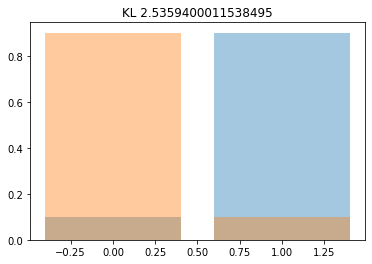

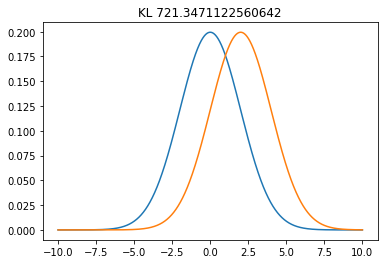

721.3471122560642


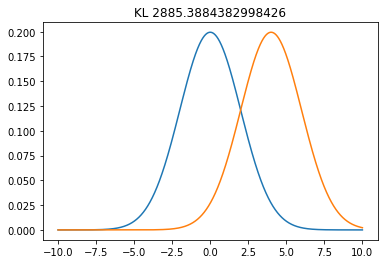

2885.3884382998426
Looks about right


In [20]:
from scipy.stats import norm

def kl(p,q):
    '''Calculate KL divergence of q from p
    D(X||Y) = sum over events i of p(i)*log(p(i)/q(i))
    '''
    
    d = np.zeros(p.shape)
    
    
    d = p*np.log2(p/q)
    
    return np.sum(d)
x = np.array([0,1])
p = np.array([.1,.9])
q = np.array([.9,.1])
plt.bar(x,p,alpha=.4)
plt.bar(x,q,alpha=.4)
plt.title('KL ' + str(kl(p,q)))
plt.show()

x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 2, 2)
plt.plot(x,p)
plt.plot(x,q)
plt.title('KL '+ str(kl(p,q)))
plt.show()
print(kl(p,q))
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 4, 2)
plt.plot(x,p)
plt.plot(x,q)
plt.title('KL '+ str(kl(p,q)))
plt.show()
print(kl(p,q))
print('Looks about right')

# Mutual information time
We will know the true distribution of the environment $E$, however we will have a predicted distribution of the environment $\hat{E}$ through the prediction system which should be a part of the agent




The environment $E$ will be drawn from the probability distribution that we will have access to, or can be calculated from the data through (monte carlo) methods, starting at random state and seeing where it will go next (to ensure starting from each state evenly).

The agents prediction of the environment next state should be sampled from the agents distribution. The output of the agent will be based on both the preceding environment and the preceding agent state. 

Ideally, the agent will perfectly model the environment when the agent doesn't have direct access to the environment state.

Given what the agent takes in, we should be able to get the the distribution based on either feeding appropriate values into the estimation function. From this we can apporximate the normal entropy, the conditional entropy given the previous environment state, and the conditional entropy given the previous agent state

# Here will be the attempt to calculate NTIC

$ NTIC = I(Y_{t+1};E_t) - I(Y_{t+1};E_t|Y_t) $

$I(Y_{t+1};E_t) = H(Y_{t+1}) - H(Y_{t+1}|E_t)$

$I(Y_{t+1};E_t|Y_t) = H(Y_{t+1}|Y_t) - H(Y_{t+1}|E_t,Y_t)$


In [21]:
#This is the cell of all cells that will calculate NTIC

def ntic(pxpypz):
    '''Compute the non-trivial information closure defined above
    assuming
    px=p(y_t+1)
    py = p(y_t)
    pz = p(e_t)    
    '''
    hy1 = calc_entropy(np.sum(pxpypz,axis=(1,2)))
    
    
    
    pxpzpy = np.moveaxis(pxpypz,1,2)
    hy1ge = condit_entropy_2g1(pxpzpy)
    hy1gy = condit_entropy_2g1(pxpypz)
    hy1gey = condit_entropy_2(pxpypz)
    
    print('H(Y_t+1)',hy1)
    print('H(Y_t+1|e_t',hy1ge)
    print('H(Y_t+1|Y_t)',hy1gy)
    print('H(Y_t+1|E_t,Y_t)',hy1gey)
    
    ntic = (hy1 - hy1ge -(hy1gy-hy1gey))
    info_flow = hy1gy - hy1gey
    return ntic,info_flow


ntic(w)


H(Y_t+1) 1.0
H(Y_t+1|e_t 1.0
H(Y_t+1|Y_t) 1.0
H(Y_t+1|E_t,Y_t) 1.0


(0.0, 0.0)

# Looks about right, experiment time

In [22]:

#Calculate for the deterministic case
ntic_d,j_d = ntic(y1ye)
print('Deterministic:\nNTIC:{}\nJ:{}'.format(ntic_d,j_d))






H(Y_t+1) 1.9999999997114497
H(Y_t+1|e_t 0.0
H(Y_t+1|Y_t) 0.0
H(Y_t+1|E_t,Y_t) 0.0
Deterministic:
NTIC:1.9999999997114497
J:0.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# Make new environment

In [23]:

##############################################################
# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([1, 0, 0, 0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0, 0, 0, 1],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 10.0],
                  [10.0, 10.0],
                  [10.0, 0.0]])
# The covariance of each component
# Sampling for the observing model
# covars = .1 * np.tile(np.identity(2), (4, 1, 1))

#Probability of emitting value from a given state
# n_components,n_features
r_corr = .9
emissionprob = np.array([[r_corr, 1 - r_corr, 0, 0],
                        [0, r_corr, 1 - r_corr, 0],
                        [0, 0, r_corr, 1 - r_corr],
                        [1 - r_corr, 0, 0, r_corr]])

# Build an HMM instance and set parameters
model_d = hmm.MultinomialHMM(n_components=4)

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model_d.startprob_ = startprob
model_d.transmat_ = transmat
model_d.means_ = means
model_d.emissionprob_ = emissionprob
###############################################################

# Generate samples
X, Z = model_d.sample(100000)


In [13]:
ntic_l = []
j_l = []
sc_l = []
#run experiment
for i in range(30):
    print('***********{}***********'.format(i))
    mod,sc = run_trials(X,num=1,num_comp=3)
    pxpypz = make_pxpypz(X, mod)
    nt,j = ntic(pxpypz)
    ntic_l.append(nt)
    j_l.append(j)
    sc_l.append(sc)
    print('NTIC:{}\nJ:{}'.format(nt,j))

***********0***********
Score of 0: -98924.91136907876
New best -98924.91136907876
H(Y_t+1) 1.5394374014517478
H(Y_t+1|e_t 0.46270409447644634
H(Y_t+1|Y_t) 0.676818308401014
H(Y_t+1|E_t,Y_t) 0.125689486814894
NTIC:0.5256044853891816
J:0.55112882158612
***********1***********


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Score of 0: -107489.06279301779
New best -107489.06279301779
H(Y_t+1) 1.1851607092469183
H(Y_t+1|e_t 0.6440177064125864
H(Y_t+1|Y_t) 0.19922326321749653
H(Y_t+1|E_t,Y_t) 0.11270703850103961
NTIC:0.454626778117875
J:0.08651622471645692
***********2***********


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Score of 0: -105885.32136236454
New best -105885.32136236454
H(Y_t+1) 1.0491938897437156
H(Y_t+1|e_t 0.5073493404033057
H(Y_t+1|Y_t) 0.04128058121466431
H(Y_t+1|E_t,Y_t) 0.0224445557792571
NTIC:0.5230085239050027
J:0.01883602543540721
***********3***********


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

3
[0.5256044853891816, 0.454626778117875, 0.5230085239050027]


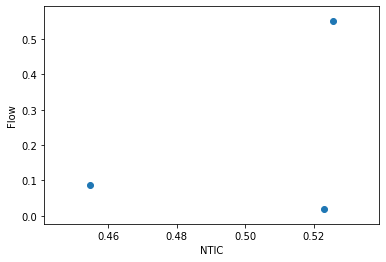

Text(0.5, 0, 'Log-likelihood Score')

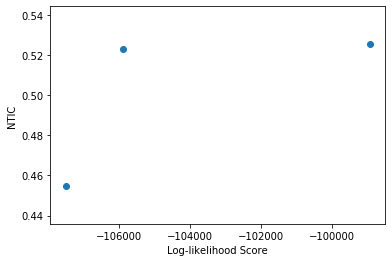

In [14]:
print(len(ntic_l))

print(ntic_l)
plt.scatter(ntic_l,j_l)
plt.xlabel('NTIC')
plt.ylabel('Flow')
plt.show()

plt.scatter(sc_l,ntic_l)
plt.ylabel('NTIC')
plt.xlabel('Log-likelihood Score')

# Layout

The environment is modelled as a hidden markov model which starts with the state $E_t$. Where the next state $E_{t+1}$ is a distribution determined from the transfer matrix $T$ via:

$$E_{t+1} = E_tT$$

Since this state isn't observable, the 'hidden' state emits observations through the emission matrix $Z$. Thus:

$$e_{t+1} = E_tTZ$$

and finally the joint distribution is 

$$e_{t+1} = e_tZ^TTZ$$

$e_t$ is the environmental observation at time t

$e_{t+1}$ is the enviso



# Modelling the environment

We assume that there system $Y$ which attempts to model the environment through only the perceived observations. Thus, the system tries to fit the function:

$$f(e_t) = \hat{e}_{t+1}$$

While this seems to be a function of strictly the previous 


# Showing as it is control theory

$$\dot{X_t} = AX + BU$$


# Get 3 variable joint distr

In [52]:
##############################################################
# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([1, 0, 0, 0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0, 0, 0, 1],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 10.0],
                  [10.0, 10.0],
                  [10.0, 0.0]])
# The covariance of each component
# Sampling for the observing model
# covars = .1 * np.tile(np.identity(2), (4, 1, 1))

#Probability of emitting value from a given state
# n_components,n_features
r_corr = 1
emissionprob = np.array([[r_corr, 1 - r_corr, 0, 0],
                        [0, r_corr, 1 - r_corr, 0],
                        [0, 0, r_corr, 1 - r_corr],
                        [1 - r_corr, 0, 0, r_corr]])

# Build an HMM instance and set parameters
model_d2 = hmm.MultinomialHMM(n_components=4)

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model_d2.startprob_ = startprob
model_d2.transmat_ = transmat
model_d2.means_ = means
model_d2.emissionprob_ = emissionprob
###############################################################

# Generate samples
X, Z = model_d2.sample(100000)

In [49]:
#Estimate it
q = np.vstack([X[:,0],Z])
model_d_est = hmm.MultinomialHMM(n_components=8)
# model_d2_est.fit(q)

In [51]:

# print(X)

st = 0

print(model_d_est.predict([[st]]))

#Predict posterior probability for each state, should be trans mat of 1
print(model_d_est.predict_proba([[st]]))

model_d_est.sample()

print('transmat',model_d_est.transmat_)

print('Testing here:')
#We assume the estimated model is our "Agent"
for i in range(X.shape[0]):
    #current observation given the previous observation
    obsv_g_env = model_d_est.predict([[Z[i-1,0]]])
    
    obsv_g_env_ag
    print('step {}: \tstate - {}\tobsv - {} '.format(i,X[i,0],Z[i]))
    
    if i > 100:
        break
# print(q[:20])

NotFittedError: This MultinomialHMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

# Notes

Information is non-trivial if the system state can predict the environment, sharing mutual information:
$$I(Y_{t+t};E_t) >0$$



# Pytorch LSTM


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# torch.set_default_tensor_type('torch.LongTensor')

In [21]:
q[0,:-1].shape

(9999,)

In [23]:
#Here we actuall do it right
num_epochs = 1000
def one_hot(a):
    '''takes in 1d np, gives out one hot
    [0] = [1 0 0 0]
    [3] = [0 0 0 1]'''
    print(a.shape)
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

#Assuming we have X_t, predict X_t+1
q = np.array(X.T)
x_train = q[0,:-1]
y_train = q[0,1:]
x_train = one_hot(x_train)
# y_train = one_hot(y_train)

x_train = np.expand_dims(x_train,1)
y_train = np.expand_dims(y_train,1)


x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

#We need samples, batch, in_shape
print("X",x_train.shape, x_train.type())
print("Y",y_train.shape, y_train.type())

#Stuff
mod = nn.LSTM(4,4)
mod2 = nn.Linear(4,4)
sig = nn.Sigmoid()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(mod.parameters(),lr=.01)

weights = None

#Train
print('Training')
for t in range(num_epochs):
    mod.zero_grad()
    
#     tlstm.hidden = tlstm.init_hidden()
    
    #Forward
    y_pred, weights  = mod(x_train,weights)
    y_pred = sig(y_pred)
#     y_pred = mod2(y_pred)
#     print('y_train',y_train[:,0].shape,y_train.type())
#     print('y_pred',y_pred[:,0,:].shape,y_pred.type())
    loss= loss_fn(y_pred[:,0,:],y_train[:,0])
    
    opt.zero_grad()
    
    loss.backward(retain_graph=True)
    
    opt.step()
    
    if t%5 == 0:
        print("Epoch ", t, "Cross Entropy:",loss.item())



# tout = np.sin(tinp)
# tout = np.expand_dims(tout,-1)
# tout = np.expand_dims(tout,-1)
# # tout = np.expand_dims(tout,-1)
# tout = torch.from_numpy(tout).float()

# # loss = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()
# o

# print(opt)
# print(tin.shape,tout.shape)
# print(tin.type(),tout.type())

# for t in range(num_epochs):
#     tlstm.zero_grad()
    
# #     tlstm.hidden = tlstm.init_hidden()
    
#     #Forward
#     y_pred, _ = tlstm(tin)
#     loss = loss_fn(y_pred,tout)
    
#     opt.zero_grad()
    
#     loss.backward()
    
#     opt.step()
    
#     if t%100 == 0:
#         print("Epoch ", t, "MSE:",loss.item())

# out = loss(tin,tout)
# print(out)
# out.backward()

#out,hidden = tlstm(tin)
# print(tout)

(9999,)
X torch.Size([9999, 1, 4]) torch.FloatTensor
Y torch.Size([9999, 1]) torch.LongTensor
Training
Epoch  0 Cross Entropy: 1.3862110376358032
Epoch  5 Cross Entropy: 1.3809031248092651
Epoch  10 Cross Entropy: 1.376273274421692
Epoch  15 Cross Entropy: 1.370802402496338
Epoch  20 Cross Entropy: 1.3638666868209839


KeyboardInterrupt: 

In [ ]:
print(x_train.shape)

In [26]:

# y_pred, weights  = mod(x_train[0].unsqueeze(0))

# #Store yt+1,y,e
# y1ye = np.zeros((4,4,4))

# for i in range(x_train.shape[0]):
#     #Predict one
#     y_pred, weights  = mod(x_train[i].unsqueeze(0))
#     y_pred = sig(y_pred)
    
#     y_pred = np.argmax(y_pred.detach().numpy()[0,0])
#     x_cur = np.argmax(x_train[i].numpy()[0])
    
#     if i > 0 and i < x_train.shape[0] -1:
#         print('y1',y_pred,'y',y, 'e',x_cur )
#     y = y_pred
        
def make_pxpypz_nn(x_train, mod, weight_flag = True):
    y_pred, weights  = mod(x_train[0].unsqueeze(0))

    #Store yt+1,y,e
    y1ye = np.zeros((4,4,4))

    for i in range(x_train.shape[0]):
        #Predict one
        if weight_flag:
            y_pred, weights  = mod(x_train[i].unsqueeze(0),weights)
        else:
            y_pred, weights  = mod(x_train[i].unsqueeze(0))
        
        y_pred = sig(y_pred)

        y_pred = np.argmax(y_pred.detach().numpy()[0,0])
        x_cur = np.argmax(x_train[i].numpy()[0])

        if i > 0 and i < x_train.shape[0] -1:
#             print('y1',y_pred,'y',y, 'e',x_cur )
            y1ye[y_pred,y,x_cur] += 1
        y = y_pred
    
    return y1ye

    
pxpypz_nn_w = make_pxpypz_nn(x_train, mod, weight_flag = True)
pxpypz_nn_nw = make_pxpypz_nn(x_train, mod, weight_flag = False)


# The prediction here is that the LSTM with state will have higher NTIC and lower J than the LSTM with no state.

In [ ]:
print(ntic(pxpypz_nn_nw))
print(ntic(pxpypz_nn_w))


In [24]:
import copy

# Lets train again and measure progress throughout

In [ ]:
#Here we actuall do it right
num_epochs = 200

#Assuming we have X_t, predict X_t+1
q = np.array(X.T)
x_train = q[0,:-1]
y_train = q[0,1:]
x_train = one_hot(x_train)
# y_train = one_hot(y_train)

x_train = np.expand_dims(x_train,1)
y_train = np.expand_dims(y_train,1)


x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

#We need samples, batch, in_shape
print("X",x_train.shape, x_train.type())
print("Y",y_train.shape, y_train.type())

#Stuff
mod_t = nn.LSTM(4,4)
mod2_t = nn.Linear(4,4)
sig_t = nn.Sigmoid()
loss_fn_t = nn.CrossEntropyLoss()
opt_t = torch.optim.Adam(mod_t.parameters(),lr=.01)

weights = None

nt_l_w= []
nt_l_nw= []
j_l_w = []
j_l_nw= []
cross_l = []

#Train
print('Training')
for t in range(num_epochs):
    mod_t.zero_grad()
    
#     tlstm.hidden = tlstm.init_hidden()
    
    #Forward
    y_pred, weights  = mod_t(x_train,weights)
    y_pred = sig_t(y_pred)
#     y_pred = mod2(y_pred)
#     print('y_train',y_train[:,0].shape,y_train.type())
#     print('y_pred',y_pred[:,0,:].shape,y_pred.type())
    loss= loss_fn_t(y_pred[:,0,:],y_train[:,0])
    
    opt_t.zero_grad()
    
    loss.backward(retain_graph=True)
    
    opt_t.step()
    
    if t%2 == 0:
        print("Epoch ", t, "Cross Entropy:",loss.item())
    if t%20 ==0:
        mt = copy.deepcopy(mod_t)
        pxpypz_nn_w = make_pxpypz_nn(x_train, mt, weight_flag = True)
        nt,j = ntic(pxpypz_nn_w)
        nt_l_w.append(nt)
        j_l_w.append(j)
        
        
        pxpypz_nn_nw = make_pxpypz_nn(x_train, mt, weight_flag = False)
        nt,j = ntic(pxpypz_nn_nw)
        nt_l_nw.append(nt)
        j_l_nw.append(j)
        
        cross_l.append(loss.item())

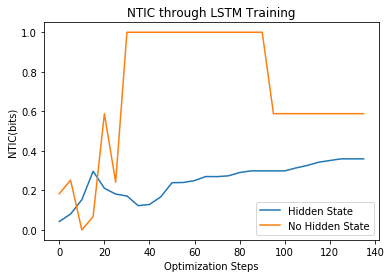

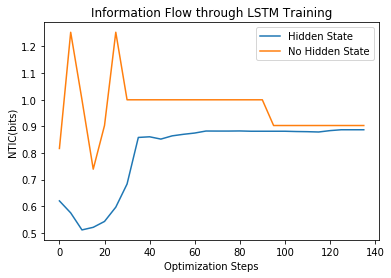

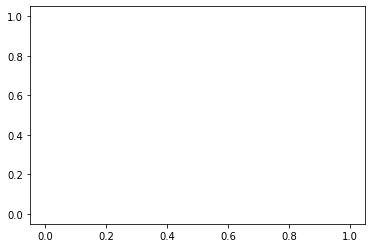

In [45]:
steps = np.arange(len(nt_l_w))*5
plt.plot(steps,nt_l_w,label='Hidden State')
plt.plot(steps,nt_l_nw,label='No Hidden State')
plt.xlabel('Optimization Steps')
plt.ylabel('NTIC(bits)')
plt.title('NTIC through LSTM Training')
plt.legend()

plt.figure()
plt.plot(steps,j_l_w, label = 'Hidden State')
plt.plot(steps,j_l_nw,label='No Hidden State')
plt.xlabel('Optimization Steps')
plt.ylabel('NTIC(bits)')
plt.title('Information Flow through LSTM Training')
plt.legend()

plt.figure()
plt.plot(cross_l)


In [29]:
mt = copy.deepcopy(mod_t)
pxpypz_nn_w = make_pxpypz_nn(x_train, mt, weight_flag = True)
print(pxpypz)
nt,j = ntic(pxpypz_nn_w)

[[[0.000 0.000 0.000 0.000]
  [22516.000 2418.000 22410.000 2263.000]
  [0.000 20.000 79.000 20.000]
  [0.000 0.000 0.000 0.000]]

 [[2502.000 22522.000 2204.000 22174.000]
  [0.000 0.000 0.000 0.000]
  [26.000 0.000 208.000 0.000]
  [0.000 0.000 0.000 0.000]]

 [[7.000 47.000 0.000 270.000]
  [29.000 0.000 0.000 0.000]
  [0.000 0.000 70.000 213.000]
  [0.000 0.000 0.000 0.000]]

 [[0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]
  [0.000 0.000 0.000 0.000]]]
H(Y_t+1) 0.0
H(Y_t+1|e_t 0.0
H(Y_t+1|Y_t) 0.0
H(Y_t+1|E_t,Y_t) 0.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss_fn(input, target)
print(input.type())
print(target.type())
print(output)

In [ ]:
components = 1
lstm = nn.LSTM(components,4)
criterion = nn.CrossEntropyLoss()

# initialize the hidden state.
hidden = (torch.randn(1,1, 4).long())

# inputs = [torch.randn(1, 3) for _ in range(5)]

In [ ]:
in1 = np.expand_dims(q[0,:-1],-1)
in1 = np.expand_dims(in1,-1)
in1 = torch.from_numpy(in1).long()
out1 = np.expand_dims(q[0,1:],-1)
out1 = np.expand_dims(out1,-1)
out1 = torch.from_numpy(out1).long()
print(in1.shape,out1.shape)

print(in1.type(),out1.type())